In [72]:
!pip uninstall qiskit -y
!pip install qiskit-aer
!pip install qiskit

Found existing installation: qiskit 0.45.1
Uninstalling qiskit-0.45.1:
  Successfully uninstalled qiskit-0.45.1

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
  Using cached qiskit-0.45.1-py3-none-any.whl.metadata (12 kB)
Using cached qiskit-0.45.1-py3-none-any.whl (9.6 kB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
transpile-benchy 0.1.0 requires qiskit~=0.43.3, but you have qiskit 0.45.1 which is incompatible.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [73]:
# given some description of the encoding rule, expand a logical circuit into an encoded circuit
# this entails interleaving the logical circuit with syndrome measurement and error correction
# each logical operator should be expanded into the encoded manifold as well
# NOTE: we could think about how to generalize this to codes, but for now its okay to keep specific to ours
from qiskit.quantum_info import random_clifford
from qiskit import transpile, QuantumCircuit, QuantumRegister, ClassicalRegister
from quantum_logical.basis import RepetitionEncoding
from qiskit.quantum_info import Operator
from quantum_logical.encoded_layout import EncodedEquivalenceLibrary, EncodedRegisters
from qiskit.circuit.library import ZGate, XGate, CZGate
from quantum_logical.deprecated.unitary_util import ImplicitUnitaryGate
from quantum_logical.encoded_layout import LogicalEncodingTransform
from qiskit.transpiler import PassManager
import numpy as np
from qiskit.circuit.parameter import Parameter
from qiskit.circuit import Delay

In [74]:
encoding1 = RepetitionEncoding(phase_flip=True)

/home/evm9/quantum_logical/.venv/lib/python3.9/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


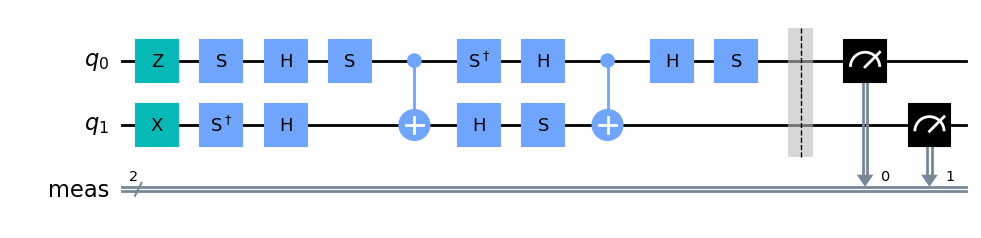

In [75]:
# Initialize a random Clifford circuit and transpile it with specific basis gates and optimization levels for encoding and transformation.

input_circuit = random_clifford(2, seed=1).to_circuit()
input_circuit = transpile(
    input_circuit,
    basis_gates=["sdg", "s", "h", "hdg", "x", "xdg", "z", "zdg", "cx", "id"],
    optimization_level=3,
)
input_circuit.measure_all()
input_circuit.draw(output="mpl")

To create logical operators use the following transformation:
\begin{align*}
A = |L_0\rangle\langle0| + |L_1\rangle\langle1|\\
U' = A U A^\dagger
\end{align*}
where U is the logical unitary that acts on the $|0\rangle$ and $|1\rangle$ states.


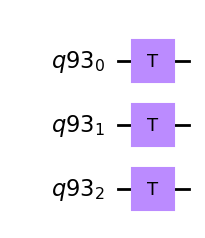

In [76]:
# ## Logical Operator Transformation
# Describing the transformation rule for logical operators and applying it to the quantum circuit.

qr = QuantumRegister(3)
logical_circuit = QuantumCircuit(qr)
logical_circuit.t(0)
logical_circuit.t(1)
logical_circuit.t(2)
# logical_circuit.x(0)
# logical_circuit.x(1)
# logical_circuit.x(2)
# logical_circuit.z(qr)

logical_circuit.draw("mpl")

In [77]:
# Converting encoded operators into logical operators

encoding_transform = encoding1.transform_operator.full()
logical_op = (
    encoding_transform.conj().T @ Operator(logical_circuit).data @ encoding_transform
)
logical_op.round()

array([[ 0.+1.j, -0.+0.j],
       [-0.+0.j,  0.+1.j]])

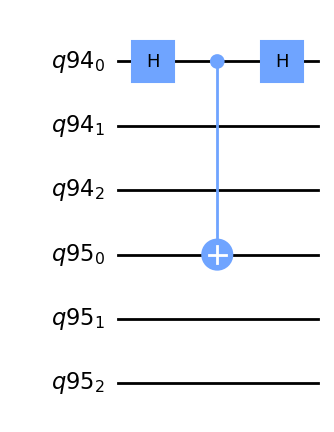

In [78]:
qr1, qr2 = QuantumRegister(3), QuantumRegister(3)
logical_circuit2 = QuantumCircuit(qr1, qr2)
# logical_circuit3.cx(qr1[0], qr2[0])
# logical_circuit3.cx(qr1[1], qr2[1])
# logical_circuit3.cx(qr1[2], qr2[2])
logical_circuit2.h(qr1[0])
logical_circuit2.cx(qr1[0], qr2[0])
logical_circuit2.h(qr1[0])
# logical_circuit2.cz(qr1[0], qr2[0])
logical_circuit2.draw("mpl")

In [79]:
# Converting encoded operators into logical operators

encoding_transform = encoding1.transform_operator.full()
transform_op = np.kron(encoding_transform, encoding_transform)
logical_op = transform_op.conj().T @ Operator(logical_circuit2).data @ transform_op
logical_op.round()

array([[ 1.+0.j, -0.+0.j,  0.+0.j,  0.+0.j],
       [-0.+0.j,  1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j, -0.+0.j],
       [-0.+0.j, -0.+0.j,  0.+0.j, -1.+0.j]])

In [80]:
# Converting logical operators into encoded operators
encoding2 = RepetitionEncoding(phase_flip=False)
encoding_transform = encoding2.transform_operator.full()
inefficient_new_op = (
    encoding_transform @ XGate().to_matrix() @ encoding_transform.conj().T
)
inefficient_new_op

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j],
       [1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j]])

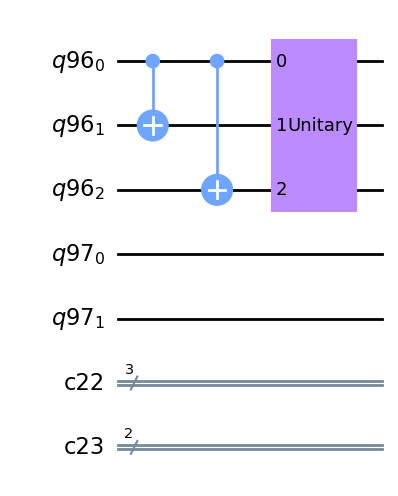

In [81]:
# ## Inefficient Decomposition Example
# Demonstrating an example of inefficient decomposition in quantum circuits.


qreg = EncodedRegisters.from_num_qubits_ancilla(3, 2)
inefficient_circuit = QuantumCircuit(*qreg)
qr = qreg.codeword_register
inefficient_circuit = encoding2.encoding_circuit(inefficient_circuit, qreg)
inefficient_circuit.append(ImplicitUnitaryGate(inefficient_new_op), qr)
inefficient_circuit.draw("mpl")

In [82]:
# ## Comparison of Operator Indices
# Analyzing the 'don't care' indices in the operator representations to understand the challenges in multi-qubit decomposition.

# Discussing the differences between the 'don't care' indices in inefficient_new_op and logical_op. Highlighting how off-diagonal indices in inefficient_new_op contrast with the diagonal assumption in logical_op, posing transpilation challenges.

print(ImplicitUnitaryGate(inefficient_new_op).to_matrix())
print("\n")
print(Operator(logical_circuit).data)

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]]


[[ 1.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.70710678+0.70710678j  0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.70710678+0.70710678j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j  

In [83]:
# transpile(
#     inefficient_circuit,
#     basis_gates=["u", "cx"],
# ).draw("mpl")

In [84]:
# Defining an encoded equivalence library to find reasonable physical circuits that equate to useful logical circuits, such as logical X, Z, CNOT gates.
encoding1_lib = EncodedEquivalenceLibrary(code_length=3)

# decomp rules specific to phase_flip = True

logical_z = QuantumCircuit(3)
logical_z.x(0)
logical_z.x(1)
logical_z.x(2)

logical_x = QuantumCircuit(3)
logical_x.z(0)
logical_x.z(1)
logical_x.z(2)

logical_cz = QuantumCircuit(6)
logical_cz.h(0)
logical_cz.cx(0, 3)
logical_cz.h(0)

logical_delay = QuantumCircuit(3)
d = Parameter("duration")
logical_delay.delay(d)

encoding1_lib.add_equivalence(ZGate(), logical_z)
encoding1_lib.add_equivalence(XGate(), logical_x)
encoding1_lib.add_equivalence(CZGate(), logical_cz)
encoding1_lib.add_equivalence(Delay(d), logical_delay)
logical_basis_gates = [k.name for k in encoding1_lib.keys()]

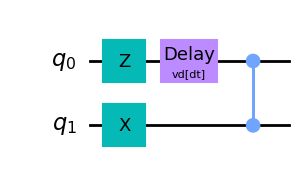

In [85]:
simple_input = QuantumCircuit(2)
d = Parameter("vd")
simple_input.z(0)
simple_input.x(1)
simple_input.delay(d, 0)
simple_input.cz(0, 1)

# first, prepare input for the encoded circuit expansion pass
simple_input = transpile(
    simple_input,
    basis_gates=logical_basis_gates,
    optimization_level=3,
)
# simple_input.measure_all()
simple_input.draw("mpl")

In [86]:
# # TODO
# simple_input = QuantumCircuit(1)
# simple_input.x(0)
# simple_input.delay(100, 0)

# # first, prepare input for the encoded circuit expansion pass
# simple_input = transpile(
#     simple_input,
#     basis_gates=logical_basis_gates,
#     optimization_level=3,
# )

# simple_input.draw("mpl")

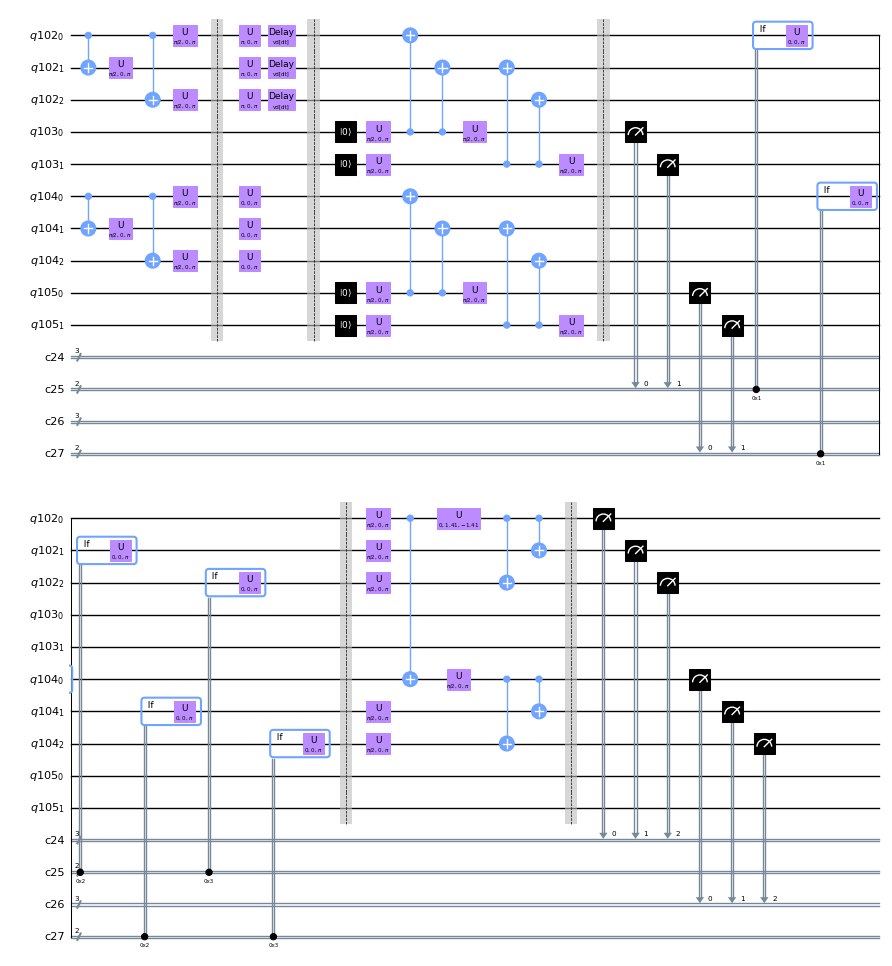

In [87]:
translator = LogicalEncodingTransform(
    encoding1, encoding1_lib, target_basis=["x", "z", "cx", "delay", "measure"]
)
simple_output_prep = translator(simple_input)

# second, optimize within the encoded basis
physical_basis_gates = ["u", "cx", "if_else"]
simple_output = transpile(
    simple_output_prep,
    basis_gates=physical_basis_gates,
    optimization_level=3,
)

simple_output.draw("mpl", scale=0.5)

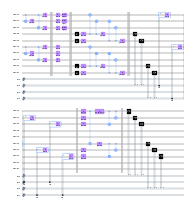

In [88]:
# bind parameters of the circuit
vd_value = 100
simple_input = simple_input.assign_parameters({d: vd_value})
simple_output = simple_output.assign_parameters({d: vd_value})
simple_output.draw("mpl", scale=0.1)

In [89]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Kraus, SuperOp
from qiskit_aer import AerSimulator
from qiskit.tools.visualization import plot_histogram

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    pauli_error,
    depolarizing_error,
    thermal_relaxation_error,
)

# Example error probabilities
p_gate1 = 0.01

# QuantumError objects
error_gate1 = pauli_error([("Z", p_gate1), ("I", 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_phase_flip = NoiseModel()
noise_phase_flip.add_all_qubit_quantum_error(error_gate1, ["u", "u1", "u2", "u3"])
noise_phase_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_phase_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u', 'u1', 'u2', 'u3']
  Instructions with noise: ['cx', 'u1', 'u3', 'u2', 'u']
  All-qubits errors: ['u', 'u1', 'u2', 'u3', 'cx']


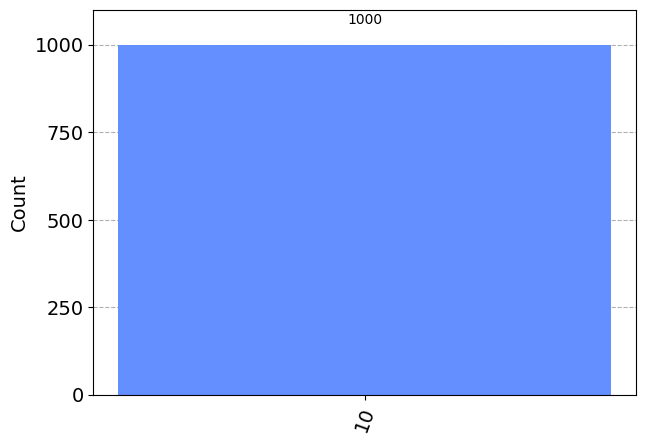

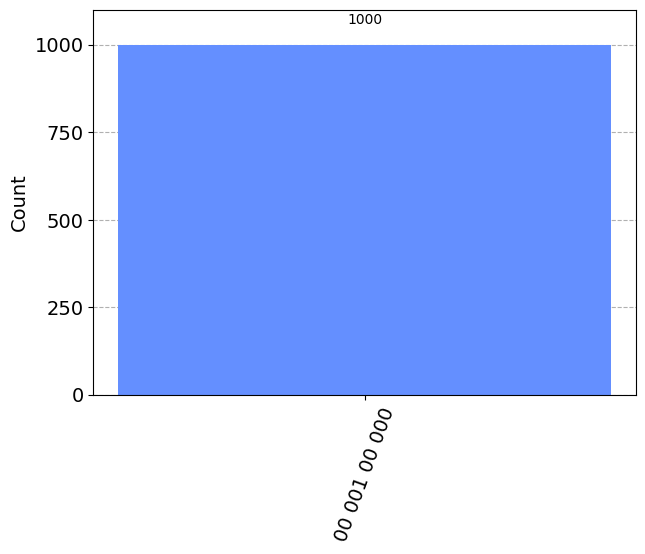

In [90]:
from qiskit import Aer
from qiskit.visualization import plot_histogram

# We first choose a simulator as our backend without any noise
backend = Aer.get_backend("qasm_simulator")

simple_input.measure_all()
counts = backend.run(simple_input, shots=1000).result().get_counts()
display(plot_histogram(counts))

# We run the simulation and get the counts
counts = backend.run(simple_output, shots=1000).result().get_counts()
# And now we plot a histogram to see the possible outcomes and corresponding probabilities
display(plot_histogram(counts))

# compare to a simple noise model

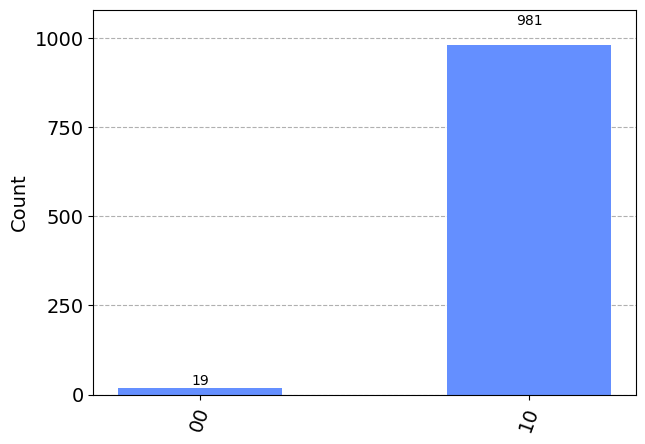

In [91]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_phase_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(simple_input, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise, shots=1000).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

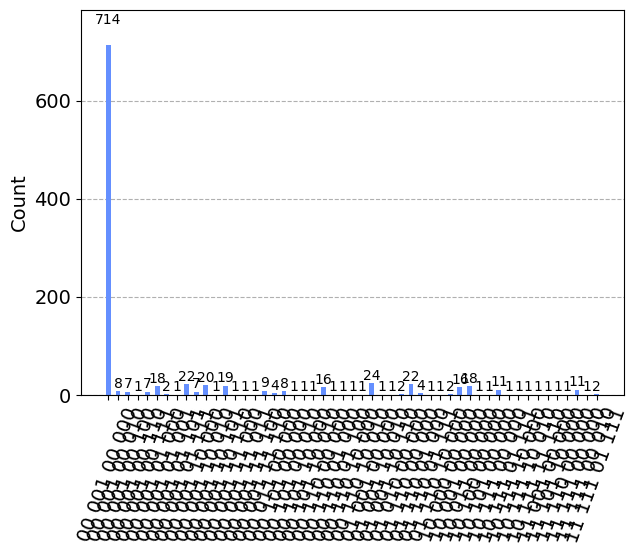

In [92]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_phase_flip)

# Transpile circuit for noisy basis gates
circ_tnoise = transpile(simple_output, sim_noise)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise, shots=1000).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

In [93]:
max(counts_bit_flip)

'11 111 01 111'